In [1]:
import azureml.core
from azureml.core import Workspace, Experiment, Environment, ScriptRunConfig
from azureml.core.environment import DockerBuildContext
print("SDK version:", azureml.core.VERSION)


SDK version: 1.47.0


In [2]:
import numpy as np

n_gpus = 1
year_list = [[2007]] 

In [3]:
from azureml.core import Dataset
from azureml.data import OutputFileDatasetConfig

ws = Workspace.from_config()
datastore = ws.get_default_datastore()
datafldr_path = Dataset.File.from_files(datastore.path('credit_risk_data/')).as_named_input('data').as_mount()
output = OutputFileDatasetConfig(destination=(datastore, 'outputs/profiles/')).as_upload(overwrite=True)

In [4]:
ws = Workspace.from_config()
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep='\n')

datastore = ws.get_default_datastore()
print("Default datastore's name: {}".format(datastore.name))

gpu-eastus-ws
aml-resources
eastus
abf00999-14b9-4c55-8975-c472a54c14c3
Default datastore's name: workspaceblobstore


In [5]:
experiment_name = 'credit-default-risk-sample'
experiment = Experiment(workspace=ws, name=experiment_name)


In [6]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

if n_gpus>=1:
    cluster_name = 'gpu-cluster'
else:
    cluster_name = 'cpu-cluster'

if cluster_name in ws.compute_targets:
    gpu_cluster = ws.compute_targets[cluster_name]
    if gpu_cluster and type(gpu_cluster) is AmlCompute:
        print('Found compute target. Will use {0} '.format(cluster_name))
else:
    print('creating new cluster')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = 'Standard_NC6s_v3',  #'Standard_M128s'
                                                                max_nodes = 1,
                                                                idle_seconds_before_scaledown = 600,
                                                                vm_priority = "lowpriority")
    
    gpu_cluster = ComputeTarget.create(ws, cluster_name, provisioning_config)
    gpu_cluster.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)
    
# use get_status() to get a detailed status for the current cluster 
print(gpu_cluster.get_status().serialize())

Found compute target. Will use gpu-cluster 
{'currentNodeCount': 1, 'targetNodeCount': 1, 'nodeStateCounts': {'preparingNodeCount': 0, 'runningNodeCount': 0, 'idleNodeCount': 1, 'unusableNodeCount': 0, 'leavingNodeCount': 0, 'preemptedNodeCount': 0}, 'allocationState': 'Steady', 'allocationStateTransitionTime': '2022-12-01T13:53:52.508000+00:00', 'errors': None, 'creationTime': '2022-11-30T07:59:58.150949+00:00', 'modifiedTime': '2022-11-30T08:00:07.187224+00:00', 'provisioningState': 'Succeeded', 'provisioningStateTransitionTime': None, 'scaleSettings': {'minNodeCount': 0, 'maxNodeCount': 1, 'nodeIdleTimeBeforeScaleDown': 'PT600S'}, 'vmPriority': 'LowPriority', 'vmSize': 'STANDARD_NC6S_V3'}


In [7]:
from azureml.core import Workspace, Environment
ws = Workspace.from_config()
env_list = Environment.list(ws)
env = Environment.get(workspace=ws, name="credit")

env.docker.enabled = True
env.docker.base_image = None
env.python.user_managed_dependencies = True
env.environment_variables = None
env.python.interpreter_path = "/opt/conda/envs/rapids/bin/python"


'enabled' is deprecated. Please use the azureml.core.runconfig.DockerConfiguration object with the 'use_docker' param instead.
Property environment_variables is deprecated. Use RunConfiguration.environment_variables to set runtime variables.


In [8]:
for years in year_list:
    n_years = len(years)
    config = ScriptRunConfig(source_directory="./src", script="mortcudf.py", compute_target=gpu_cluster, environment=env, 
        arguments =[datafldr_path, output, n_gpus, n_years],
        # docker_runtime_config=docker_config,
    )
    run = experiment.submit(config)
    print(run)

    print(run.wait_for_completion(show_output=True))

Run(Experiment: credit-default-risk-sample,
Id: credit-default-risk-sample_1669903863_be9cca71,
Type: azureml.scriptrun,
Status: Starting)
RunId: credit-default-risk-sample_1669903863_be9cca71
Web View: https://ml.azure.com/runs/credit-default-risk-sample_1669903863_be9cca71?wsid=/subscriptions/abf00999-14b9-4c55-8975-c472a54c14c3/resourcegroups/aml-resources/workspaces/gpu-eastus-ws&tid=72f988bf-86f1-41af-91ab-2d7cd011db47

Streaming user_logs/std_log.txt

Importing read_csv, concat, merge, DataFrame, get_dummies, Series using Rapid's Libraries
Using the data already downloaded at /mnt/azureml/cr/j/863bc1d714ae41fb81d656057496201f/cap/data-capability/wd/INPUT_data. Skipping fresh download.
Reading the file Acquisition_2007Q1.txt
Reading the file Acquisition_2007Q2.txt
Reading the file Acquisition_2007Q3.txt
Reading the file Acquisition_2007Q4.txt
Time taken for reading Acquisition datasets:  2.3 secs
Acquisition raw file shape:  (1246499, 26)

Sample Acquisition Rows:
              Lo

In [9]:
metrics = run.get_metrics()
metrics

{'col_acq list is len': 26,
 'ROC': 'aml://artifactId/ExperimentRun/dcid.credit-default-risk-sample_1669903863_be9cca71//assets/ROC.png',
 'SHAP': 'aml://artifactId/ExperimentRun/dcid.credit-default-risk-sample_1669903863_be9cca71//assets/shap.png',
 'SHAP_Force': 'aml://artifactId/ExperimentRun/dcid.credit-default-risk-sample_1669903863_be9cca71//assets/shap_force.png'}

In [10]:
run.get_file_names()

['assets/ROC.png',
 'assets/shap.png',
 'assets/shap_force.png',
 'system_logs/cs_capability/cs-capability.log',
 'system_logs/data_capability/data-capability.log',
 'system_logs/data_capability/rslex.log.2022-12-01-14',
 'system_logs/hosttools_capability/hosttools-capability.log',
 'system_logs/lifecycler/execution-wrapper.log',
 'system_logs/lifecycler/lifecycler.log',
 'system_logs/metrics_capability/metrics-capability.log',
 'system_logs/snapshot_capability/snapshot-capability.log',
 'user_logs/std_log.txt']

In [11]:
os.makedirs('files', exist_ok=True)

for f in run.get_file_names():
    if not f.startswith('assets'):
        continue
    dest = os.path.join('files', f.split('/')[-1])
    print('Downloading file {} to {}...'.format(f, dest))
    run.download_file(f, dest)   


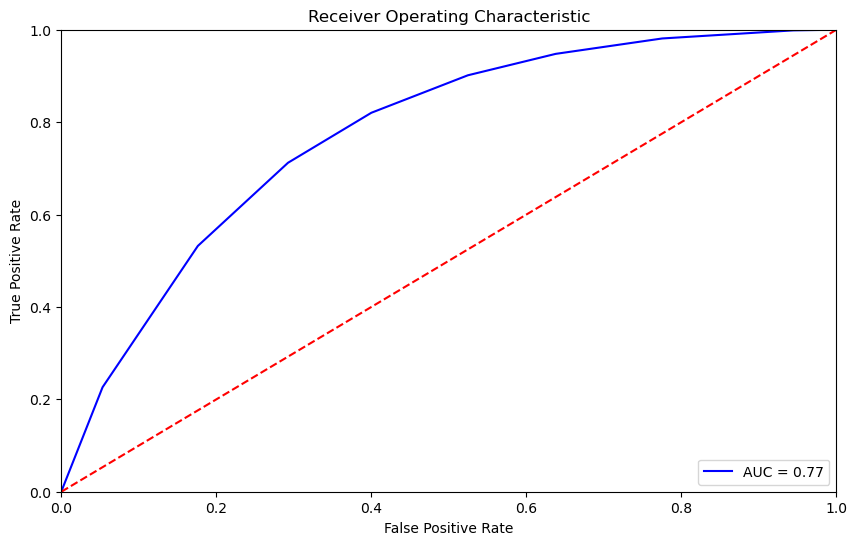

In [12]:
from IPython.display import Image
Image(filename='files/ROC.png') 

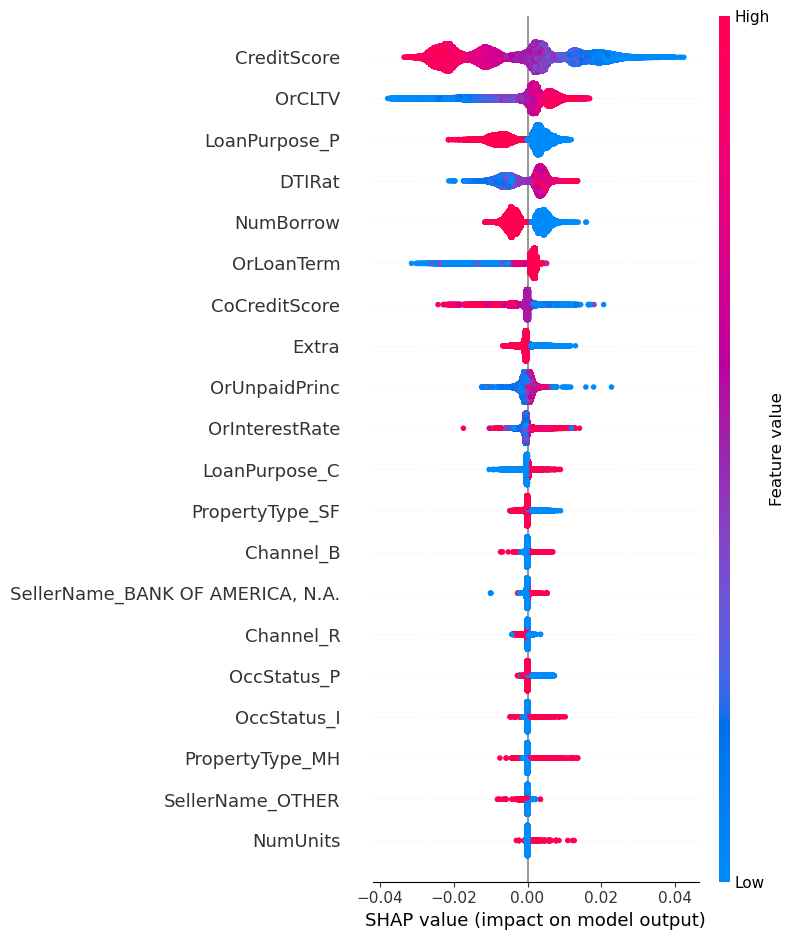

In [13]:
from IPython.display import Image
Image(filename='files/shap.png') 

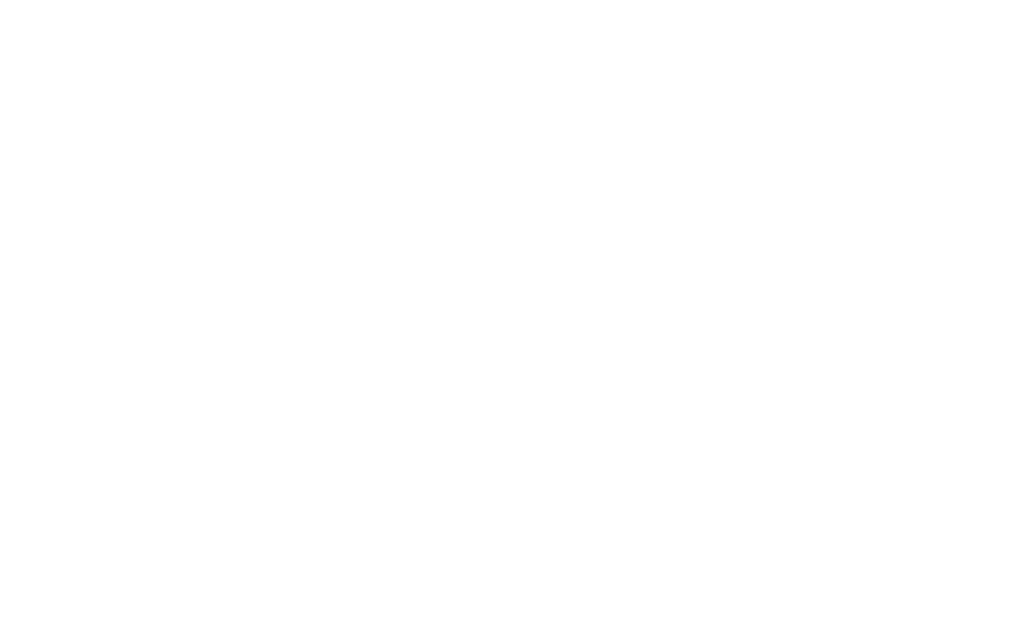